In [ ]:
#download Casia WebFace
import gdown
file_id = '1KxNCrXzln0lal3N4JiYl9cFOIhT78y1l'
gdown.download(f'https://drive.google.com/uc?id={file_id}', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KxNCrXzln0lal3N4JiYl9cFOIhT78y1l
From (redirected): https://drive.google.com/uc?id=1KxNCrXzln0lal3N4JiYl9cFOIhT78y1l&confirm=t&uuid=f50436e4-3e5d-4e09-95e4-dbdd96de2ec6
To: /content/faces_webface_112x112.zip
100%|██████████| 2.79G/2.79G [00:31<00:00, 87.2MB/s]


'faces_webface_112x112.zip'

In [ ]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [ ]:
#Don't run, update the package
/usr/local/lib/python3.10/dist-packages/mxnet/numpy/utils.py

In [ ]:
import zipfile

with zipfile.ZipFile('/content/faces_webface_112x112.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/Casia')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp  '/content/drive/MyDrive/face_data_mapping.pkl' '/content/'

drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
import pickle

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import pickle
import tensorflow_hub as hub
import random
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
import cv2

# !rm -rf /content/.cache && rm -rf /tmp/*
# from google.colab import drive

# drive.mount('/content/drive')

# !cp /content/drive/MyDrive/FaceData/data_test.pkl /content
# !cp /content/drive/MyDrive/FaceData/data_train.pkl /content

# drive.flush_and_unmount()

# with open('data_test.pkl', 'rb') as f:
#     test_df = pickle.load(f)

# with open('data_train.pkl', 'rb') as f:
#     train_df = pickle.load(f)

# x_train = train_df['image']
# y_train = train_df['person']

# x_test = test_df['image']
# y_test = test_df['person']

# def remove_extra_dim(image):
#     try:
#         return np.squeeze(image, axis=0)  # Efficient removal if size 1
#     except ValueError:
#         # Extra dimension not found, return the original data
#         print('failed')
#         return image

# Loop through each image in the Series
# for index, image in x_train.items():  # Access elements using items()
#     x_train.loc[index] = remove_extra_dim(image)  # Modify Series in-place

# for index, image in x_test.items():  # Access elements using items()
#     x_test.loc[index] = remove_extra_dim(image)  # Modify Series in-place

# x_train[0].shape

# x_train.shape

# classes = set()
# for i in y_train:
#   classes.add(i)

# classes = list(classes)
# classes

def data_generator(batch_size=120):

  dataDIR = '/content/Casia/faces_webface_112x112/'
  rec_file = dataDIR+'train.rec'
  idx_file = dataDIR+'train.idx'

  with open('face_data_mapping.pkl','rb') as f:
    label_wise_sample = pickle.load(f)

  while True:
    a = []
    p = []
    n = []
    for _ in range(batch_size):
      found = True
      while(found):
        pos_neg = random.sample(list(label_wise_sample.keys()), 2)
        try:
          positive_samples = random.sample((label_wise_sample[pos_neg [0]]), 2)
          negative_sample= random.sample((label_wise_sample[pos_neg [1]]),1)
          found = False
        except:
          continue

      record = mx.recordio.MXIndexedRecordIO(idx_file, rec_file, 'r')
      label_wise_index = dict()
      a_img_ind = positive_samples[0]
      p_img_ind = positive_samples[1]
      n_img_ind = negative_sample[0]

      images = []

      image_record = record.read_idx(a_img_ind)
      headerA, imageA = mx.recordio.unpack_img(image_record)

      images.append(imageA)

      image_record = record.read_idx(p_img_ind)
      headerP, imageP = mx.recordio.unpack_img(image_record)

      images.append(imageP)


      image_record = record.read_idx(n_img_ind)
      headerN, imageN = mx.recordio.unpack_img(image_record)

      images.append(imageN)

      processedImages = []

      for i in images:
        image = i[:,:,::-1]
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        image = np.asarray(image)
        image = image.astype('float32') / 255.0
        processedImages.append(image)


      a.append(processedImages[0])
      p.append(processedImages[1])
      n.append(processedImages[2])

    yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32"))

def triplet_loss (y_true, y_pred):
  anchor_out = y_pred[:, 0:128]
  positive_out = y_pred[:, 128:256]
  negative_out = y_pred[:, 256:384]
  pos_dist = K.sum(K.abs(anchor_out-positive_out), axis=1)
  neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)
  stacked_distances = K.stack([pos_dist, neg_dist], axis=0)
  probs = K.softmax(stacked_distances, axis=0)
  return K.mean(K.abs (probs [0]) + K.abs (1.0 - probs [1]))

input_shape = (224,224,3);
input_layer = layers.Input(shape=input_shape)
inception = InceptionV3(weights='imagenet', include_top=False)
feature_extractor = inception(input_layer)
for layer in inception.layers:
    layer.trainable = False
gap_layer = layers.GlobalAveragePooling2D()(feature_extractor)
dropout_layer = layers.Dropout(rate=0.2,seed=82)(gap_layer)
fc_layer = layers.Dense(128, activation='relu')(dropout_layer)
batchNorm = layers.BatchNormalization()(fc_layer)
model = Model(inputs=input_layer, outputs=batchNorm)

model.summary()

triplet_model_a = layers.Input((224, 224, 3))
triplet_model_p = layers.Input((224, 224, 3))
triplet_model_n = layers.Input((224, 224, 3))
triplet_model_out = layers.Concatenate()([model (triplet_model_a), model (triplet_model_p), model(triplet_model_n)])
triplet_model = Model( [triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
# triplet_model.summary()

my_optimizer = keras.optimizers.Adam(0.0005)

triplet_model.compile(loss=triplet_loss, optimizer=my_optimizer)

triplet_model.fit_generator(data_generator(),steps_per_epoch=250,epochs=10)



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_189 (B  (None, 128)               512 

<ipython-input-2-25170ae4a7d9>:162: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  triplet_model.fit_generator(data_generator(),steps_per_epoch=250,epochs=10)


Epoch 1/10
 26/250 [==>...........................] - ETA: 3:10:52 - loss: 0.7552

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!cp /content/drive/MyDrive/facenet_keras.h5 /content

drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
import pandas as pd
from tqdm import tqdm

In [ ]:

model = load_model('/content/facenet_keras.h5')

ValueError: bad marshal data (unknown type code)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import pickle
import tensorflow_hub as hub
import random
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
input_shape = (224,224,3);
input_layer = layers.Input(shape=input_shape)
inception = InceptionV3(weights='imagenet', include_top=False)
feature_extractor = inception(input_layer)
for layer in inception.layers:
    layer.trainable = False
gap_layer = layers.GlobalAveragePooling2D()(feature_extractor)
dropout_layer = layers.Dropout(rate=0.2,seed=82)(gap_layer)
fc_layer = layers.Dense(128, activation='relu')(dropout_layer)
batchNorm = layers.BatchNormalization()(fc_layer)
# l2_norm_layer = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(fc_layer)
model = Model(inputs=input_layer, outputs=batchNorm)

model.summary()

triplet_model_a = layers.Input((224, 224, 3))
triplet_model_p = layers.Input((224, 224, 3))
triplet_model_n = layers.Input((224, 224, 3))
triplet_model_out = layers.Concatenate()([model (triplet_model_a), model (triplet_model_p), model(triplet_model_n)])
triplet_model = Model( [triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_189 (B  (None, 128)               512   

In [ ]:
model_path = "/content"
tf.keras.models.save_model(triplet_model,model_path)
triplet_model.save('facenetep7.h5',save_format='h5')

from google.colab import drive
drive.mount('/content/drive')

!cp /content/facenetep7.h5 /content/drive/MyDrive
!mkdir FaceNet
!mkdir FaceNet/variables
!cp /content/fingerprint.pb /content/FaceNet
!cp /content/keras_metadata.pb /content/FaceNet
!cp /content/saved_model.pb /content/FaceNet
!cp /content/variables/variables.data-00000-of-00001 /content/FaceNet/variables
!cp /content/variables/variables.index /content/FaceNet/variables

import os
from zipfile import ZipFile
with ZipFile("FaceNetep7.zip",'w') as zip_file:
  for root,_,files in os.walk('/content/FaceNet'):
    for filer in files:
      filepath = os.path.join(root,filer)
      zip_file.write(filepath,os.path.relpath(filepath,'/content/FaceNetep7'))

print('success!')

!cp /content/FaceNetep7.zip /content/drive/MyDrive
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import gdown
file_id = '1--y_Y9d7YwFJQKdMv0kso2I6WuoUZgx2'
output_file = 'FaceEmbeds.pkl'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1--y_Y9d7YwFJQKdMv0kso2I6WuoUZgx2
From (redirected): https://drive.google.com/uc?id=1--y_Y9d7YwFJQKdMv0kso2I6WuoUZgx2&confirm=t&uuid=73acb68e-14f1-4339-8411-a6d10c33a7fb
To: /content/FaceEmbeds.pkl
 31%|███       | 1.34G/4.39G [00:10<00:25, 120MB/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-15c34b4f605d>", line 5, in <cell line: 5>
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 325, in download
    for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 816, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 936, in stream
    data = self.read(amt=amt, decode_content=decode_content)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 879, in read
    data = self._raw_read(amt)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 

TypeError: object of type 'NoneType' has no len()

In [ ]:
import gdown
file_id = '1_zI2SvaJmHSqtMR_udIF_ZePgd2TL-zM'
output_file = 'model.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

In [ ]:
!unzip model.zip

Archive:  model.zip
 extracting: fingerprint.pb          
 extracting: saved_model.pb          
 extracting: keras_metadata.pb       
 extracting: variables/variables.index  
 extracting: variables/variables.data-00000-of-00001  


In [ ]:
# !unzip "/content/drive/MyDrive/FaceNetep10.zip" -d facenet

unzip:  cannot find or open /content/drive/MyDrive/FaceNetep10.zip, /content/drive/MyDrive/FaceNetep10.zip.zip or /content/drive/MyDrive/FaceNetep10.zip.ZIP.


In [ ]:
!unzip "/content/drive/MyDrive/faces-cropped (2).zip" -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/faces-cropped/n007433/0324_01.jpg  
  inflating: dataset/faces-cropped/n007433/0326_02.jpg  
  inflating: dataset/faces-cropped/n007433/0339_03.jpg  
  inflating: dataset/faces-cropped/n007433/0351_01.jpg  
  inflating: dataset/faces-cropped/n007433/0441_01.jpg  
  inflating: dataset/faces-cropped/n007433/0443_01.jpg  
  inflating: dataset/faces-cropped/n007433/0478_02.jpg  
  inflating: dataset/faces-cropped/n007433/0489_01.jpg  
   creating: dataset/faces-cropped/n007497/
  inflating: dataset/faces-cropped/n007497/0005_01.jpg  
  inflating: dataset/faces-cropped/n007497/0012_01.jpg  
  inflating: dataset/faces-cropped/n007497/0014_01.jpg  
  inflating: dataset/faces-cropped/n007497/0034_01.jpg  
  inflating: dataset/faces-cropped/n007497/0067_01.jpg  
  inflating: dataset/faces-cropped/n007497/0069_01.jpg  
  inflating: dataset/faces-cropped/n007497/0077_01.jpg  
  inflating: dataset/faces-cropped/n007497/0098_01

In [ ]:
drive.flush_and_unmount()

In [ ]:
import numpy as np
import cv2
import pickle
import tensorflow as tf
import pandas as pd
from keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow

def triplet_loss (y_true, y_pred):
  anchor_out = y_pred[:, 0:128]
  positive_out = y_pred[:, 128:256]
  negative_out = y_pred[:, 256:384]
  pos_dist = K.sum(K.abs(anchor_out-positive_out), axis=1)
  neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)
  stacked_distances = K.stack([pos_dist, neg_dist], axis=0)
  probs = K.softmax(stacked_distances, axis=0)
  return K.mean(K.abs (probs [0]) + K.abs (1.0 - probs [1]))

model = load_model('/content', custom_objects={'triplet_loss': triplet_loss})

In [ ]:
single_image_input = layers.Input(shape=(160, 160, 3), name='single_image_input')
embedding_output = model.layers[3](single_image_input)
inference_model = Model(inputs = single_image_input, outputs = embedding_output)
inference_model.set_weights(model.get_weights())
data = []

In [ ]:
#dealing with dataset
import os
from math import floor
import cv2
import random
import numpy as np
from sklearn.preprocessing import Normalizer

l2_normalizer = Normalizer('l2')
face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
classes = os.listdir('/content/dataset/faces-cropped')
imageTrainArr = []
imageTestArr = []
classesTrain = []
classesTest = []

classes.remove('class_list.txt')
for i in classes:

    path_of_folder = str("/content/dataset/faces-cropped/" + i)
    count = 0
    for j in range(2):
      dirImg = os.listdir(path_of_folder)
      opts = len(dirImg)
      index1 = random.randint(0,opts-1)
      index2 = random.randint(0,opts-1)
      imageTrainArr.append("/content/dataset/faces-cropped/" + i + '/' + dirImg[index1])
      imageTestArr.append("/content/dataset/faces-cropped/" + i + '/' +  dirImg[index2])
      classesTrain.append(i)
      classesTest.append(i)


for i in range(len(imageTrainArr)-1500):
    print(imageTrainArr[i])
    image = cv2.imread(imageTrainArr[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    try:
      (x, y, w, h) = face_classifier.detectMultiScale(gray, 1.3, 5)[0]
      image = image[y:y+h, x:x+w, :]
    except:
      image = image
    img = cv2.resize(image, (224, 224))
    img = np.asarray(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    classe = classesTrain[i]
    embed = inference_model.predict(img)
    embed = embed[0] #to be figured out tomorrow
    encode = l2_normalizer.transform(np.expand_dims(embed, axis=0))[0]
    data.append((encode,classe))


/content/dataset/faces-cropped/n007180/0145_01.jpg
1/1 [==============================] - 0s 279ms/step
/content/dataset/faces-cropped/n007180/0031_01.jpg
1/1 [==============================] - 0s 283ms/step
/content/dataset/faces-cropped/n001858/0249_06.jpg
1/1 [==============================] - 0s 314ms/step
/content/dataset/faces-cropped/n001858/0118_01.jpg
1/1 [==============================] - 1s 603ms/step
/content/dataset/faces-cropped/n003557/0102_03.jpg
1/1 [==============================] - 0s 490ms/step
/content/dataset/faces-cropped/n003557/0118_01.jpg
1/1 [==============================] - 1s 864ms/step
/content/dataset/faces-cropped/n007036/0348_01.jpg
1/1 [==============================] - 0s 378ms/step
/content/dataset/faces-cropped/n007036/0012_01.jpg
1/1 [==============================] - 1s 533ms/step
/content/dataset/faces-cropped/n006619/0334_03.jpg
1/1 [==============================] - 0s 322ms/step
/content/dataset/faces-cropped/n006619/0310_01.jpg
1/1 [========

In [ ]:
with open("FaceDatabase.pkl", "wb") as f:
    pickle.dump(data, f)

1/1 [==============================] - 0s 148ms/step
accuracy :  0.0 %  class:  n008006
1/1 [==============================] - 0s 152ms/step
accuracy :  0.0 %  class:  n003394
1/1 [==============================] - 0s 164ms/step
accuracy :  0.0 %  class:  n004539
1/1 [==============================] - 0s 152ms/step
accuracy :  25.0 %  class:  n001858
1/1 [==============================] - 0s 153ms/step
accuracy :  20.0 %  class:  n008978
1/1 [==============================] - 0s 162ms/step
accuracy :  33.33333333333333 %  class:  n003557
1/1 [==============================] - 0s 149ms/step
accuracy :  42.857142857142854 %  class:  n007036
1/1 [==============================] - 0s 146ms/step
accuracy :  37.5 %  class:  n001665
1/1 [==============================] - 0s 148ms/step
accuracy :  33.33333333333333 %  class:  n007899
1/1 [==============================] - 0s 147ms/step
accuracy :  40.0 %  class:  n006619
1/1 [==============================] - 0s 149ms/step
accuracy :  45.45454

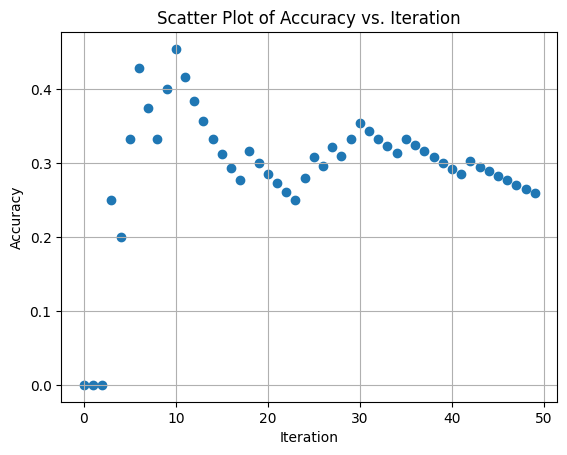

In [ ]:
correct = 0
incorrect = 0

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

with open("FaceDatabase.pkl", "rb") as f:
  data = pickle.load(f)

class_name_and_arrays = data
accur = []
for i in range(len(imageTestArr)-1500):
    image = cv2.imread(imageTestArr[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    try:
      (x, y, w, h) = face_classifier.detectMultiScale(gray, 1.3, 5)[0]
      image = image[y:y+h, x:x+w, :]
    except:
      image = image
    img = cv2.resize(image, (224, 224))
    img = np.asarray(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    classe = classesTrain[i]
    new_embedding = inference_model.predict(img)
    new_embedding = new_embedding[0] #to be figured out tomorrow
    new_embedding = l2_normalizer.transform(np.expand_dims(new_embedding, axis=0))[0]

    highest_similarity = -float('inf')  # Initialize with a negative infinity
    predicted_class_name = None

    for array,class_name in class_name_and_arrays:
      similarity = np.dot(new_embedding, array) / (np.linalg.norm(new_embedding) + np.linalg.norm(array))  # Calculate similarity
      if similarity > highest_similarity:
        highest_similarity = similarity
        predicted_class_name = class_name

    if predicted_class_name == classe:
      correct+=1
    else:
      incorrect+=1
    print("accuracy : ", (correct/(correct +incorrect))*100, "%", ' class: ',predicted_class_name)
    accur.append(correct/(correct+incorrect))

plt.scatter(range(len(accur)), accur)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Scatter Plot of Accuracy vs. Iteration")
plt.grid(True)
plt.show()


In [ ]:
accuracy = correct/(correct+incorrect)
incorrect

48

In [ ]:
correct

2

In [ ]:
import cv2
import numpy as np
import pickle


def draw_boundary(img, classifier, scaleFactor, minNeighbors, color, name):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    for (x,y,w,h) in features:
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2 )
        cv2.putText(img, name, (int(x), int(y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1, cv2.LINE_AA)


with open("FaceDatabase.pkl", "rb") as f:
    data = pickle.load(f)

class_name_and_arrays = data
path = input('image: ')
path_of_img = path
image = cv2.imread(path_of_img)
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(x, y, w, h) = face_classifier.detectMultiScale(gray, 1.3, 5)[0]
image = image[y:y+h, x:x+w, :]
img = cv2.resize(image, (224, 224))
cv2_imshow(img)
img = np.asarray(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)
new_embedding = inference_model.predict(img)
new_embedding = new_embedding[0]

highest_similarity = -float('inf')  # Initialize with a negative infinity
predicted_class_name = None

# Load the model with custom loss function
d = []
for array,class_name in class_name_and_arrays:
  d.append(array)

arr1 = d[0]
arr2 = d[1]

ssr = 0
for i in range(len(arr1)):
  ssr = ssr+(arr1[i]-arr2[i])**2

print('ssr loss: ',ssr)

for array,class_name in class_name_and_arrays:
    similarity = np.dot(new_embedding, array) / (np.linalg.norm(new_embedding) + np.linalg.norm(array))  # Calculate similarity
    print('For ',class_name,' similarity score is: ',similarity)
    if similarity > highest_similarity:
        highest_similarity = similarity
        predicted_class_name = class_name


print(highest_similarity)
print(f"Predicted class name for the new image: {predicted_class_name}")

KeyboardInterrupt: Interrupted by user

In [ ]:
img = cv2.imread('AgyaatHamlawar.png')
cv2_imshow(img)